In [1]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import sys
sys.path.append("../../..")

import matplotlib.pyplot as plt
import mplhep as hep

# %load_ext autoreload
# %autoreload 1
# %aimport longitudinalProfile.camel.emilia_samples.emilia_peak_finder
from longitudinalProfile.camel.emilia_samples.emilia_peak_finder import *

from longitudinalProfile.camel.peak_finding import *

In [2]:
def map_fct(sample_i):
    driver = EmiliaCamelFinderDriver(EmiliaSampleReader())
    driver.findPeaks(sampleRange=[sample_i], tqdm_kwargs=dict(disable=True))
    driver.addInfoToPeaks()
    driver.applyFilters()
    driver.extractMostProminentPeak()
    driver.makeHistogram()
    del driver.reader
    return driver


In [3]:
with ProcessPoolExecutor(max_workers=20) as executor:
    driver_list = list(executor.map(map_fct, range(0, 100)))

Peak finding efficiency : 43.3%
FilterLowBaseHeight - efficiency 31.4%
FilterNoisyCellsPeaksUsingBases - efficiency 70.5%
FilterDipsNotInCenter - efficiency 100.0%
Peak finding efficiency : 43.6%
FilterLowBaseHeight - efficiency 33.0%
FilterNoisyCellsPeaksUsingBases - efficiency 72.3%
FilterDipsNotInCenter - efficiency 100.0%
Peak finding efficiency : 43.4%
Peak finding efficiency : 43.8%
Peak finding efficiency : 43.7%
FilterLowBaseHeight - efficiency 31.9%
Peak finding efficiency : 43.2%
FilterNoisyCellsPeaksUsingBases - efficiency 69.5%
FilterDipsNotInCenter - efficiency 100.0%
FilterLowBaseHeight - efficiency 30.8%
Peak finding efficiency : 42.9%
Peak finding efficiency : 43.4%
Peak finding efficiency : 43.3%
Peak finding efficiency : 42.8%
FilterLowBaseHeight - efficiency 32.0%
FilterNoisyCellsPeaksUsingBases - efficiency 68.4%
Peak finding efficiency : 43.9%
FilterNoisyCellsPeaksUsingBases - efficiency 70.8%
FilterDipsNotInCenter - efficiency 100.0%
FilterLowBaseHeight - efficien

In [4]:
def merge(drivers:list[EmiliaCamelFinderDriver]) -> EmiliaCamelFinderDriver:
    out = EmiliaCamelFinderDriver(EmiliaSampleReader())
    out.peakFindingSettings = drivers[0].peakFindingSettings
    out.eventsPerBeamEnergy = sum((driver.eventsPerBeamEnergy for driver in drivers))

    out.h_length_prominenceNormalized = sum((driver.h_length_prominenceNormalized for driver in drivers))
    out.h_lengthProminence = sum((driver.h_lengthProminence for driver in drivers))


    peaksInfoDfs = [driver.peaks_df_mostProminent for driver in drivers]
    perLayerDfList = [driver.energyPerLayer_df for driver in drivers]
    keys = list(range(len(peaksInfoDfs)))
    # the reset_index will create a unique index over all batches
    concatDf = pd.concat(peaksInfoDfs, keys=keys).reset_index(names=["batchNumber", "eventInBatch"]).rename_axis(index="eventInternal")
    perLayer_concat = pd.concat((df.reset_index("rechits_layer") for df in perLayerDfList), keys=keys)

    # Now join to the per layer df so we map [batchNumber, eventInBatch] to the unique index in concat_df
    perLayer_indexed = concatDf[["batchNumber", "eventInBatch"]].join(perLayer_concat, on=["batchNumber", "eventInBatch"])#.set_index("rechits_layer", append=True)

    out.peaks_df_mostProminent = concatDf.drop(columns=["batchNumber", "eventInBatch"])
    out.energyPerLayer_df = perLayer_indexed.drop(columns=["batchNumber", "eventInBatch"]).set_index("rechits_layer", append=True)
    return out

In [5]:
merged_driver = merge(driver_list)

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


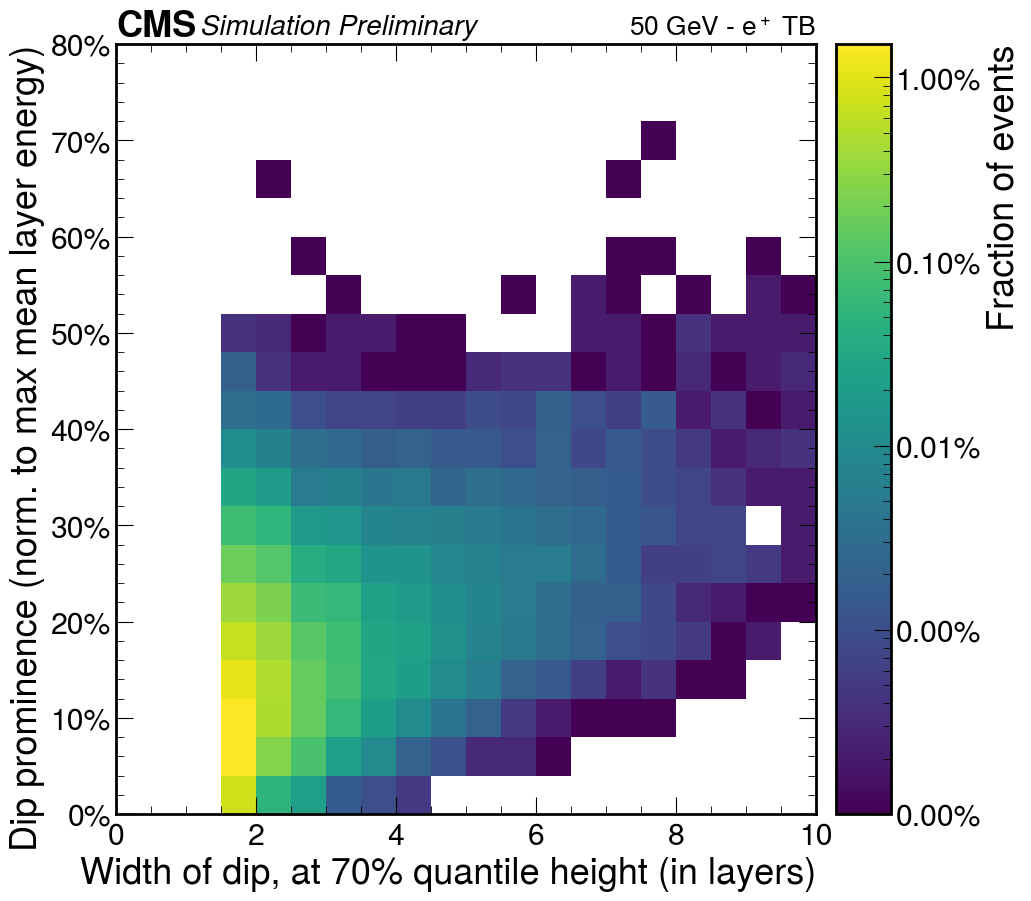

In [6]:
merged_driver.plotHistogram(50, normalizeEventCount=True)

In [7]:
eventList = merged_driver.getPassingEventList().query("prominences > 2.5 and widths > 3")
len(eventList)

31

/grid_mnt/vol_home/llr/cms/cuisset/hgcal/testbeam18/clue3d-dev/src/Plotting/longitudinalProfile/camel/emilia_samples/../../../longitudinalProfile/camel/plot.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


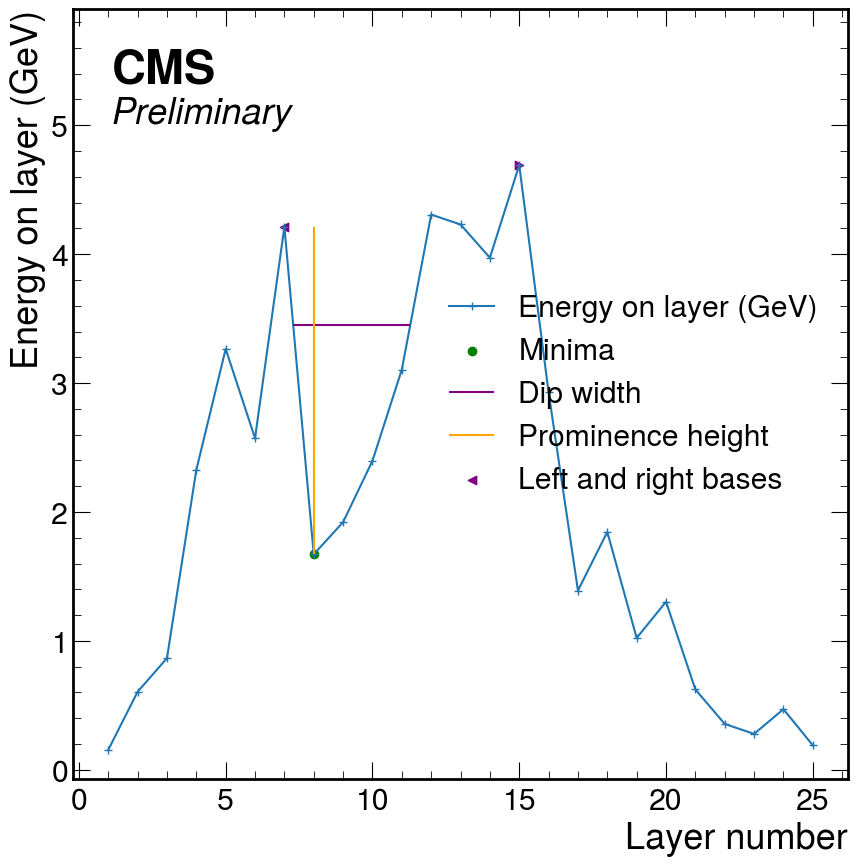

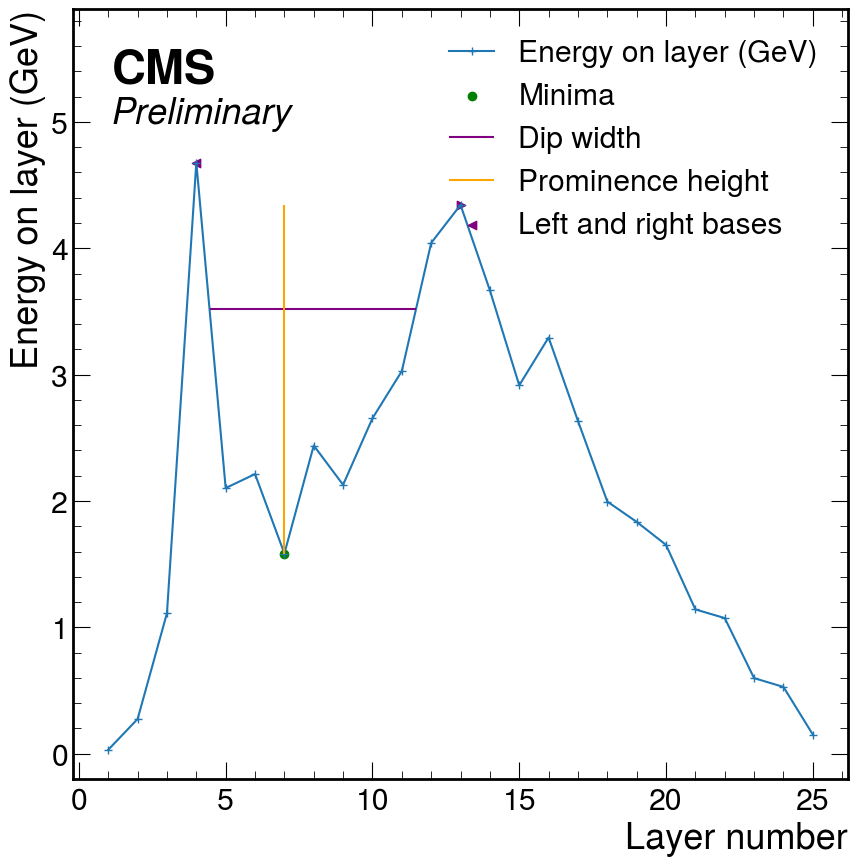

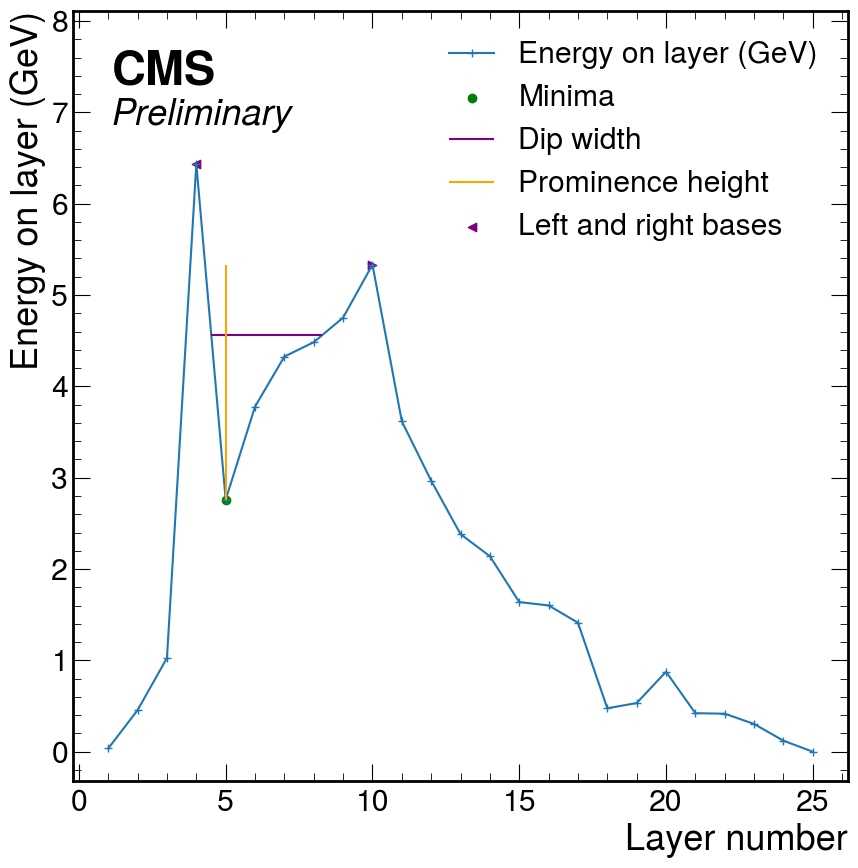

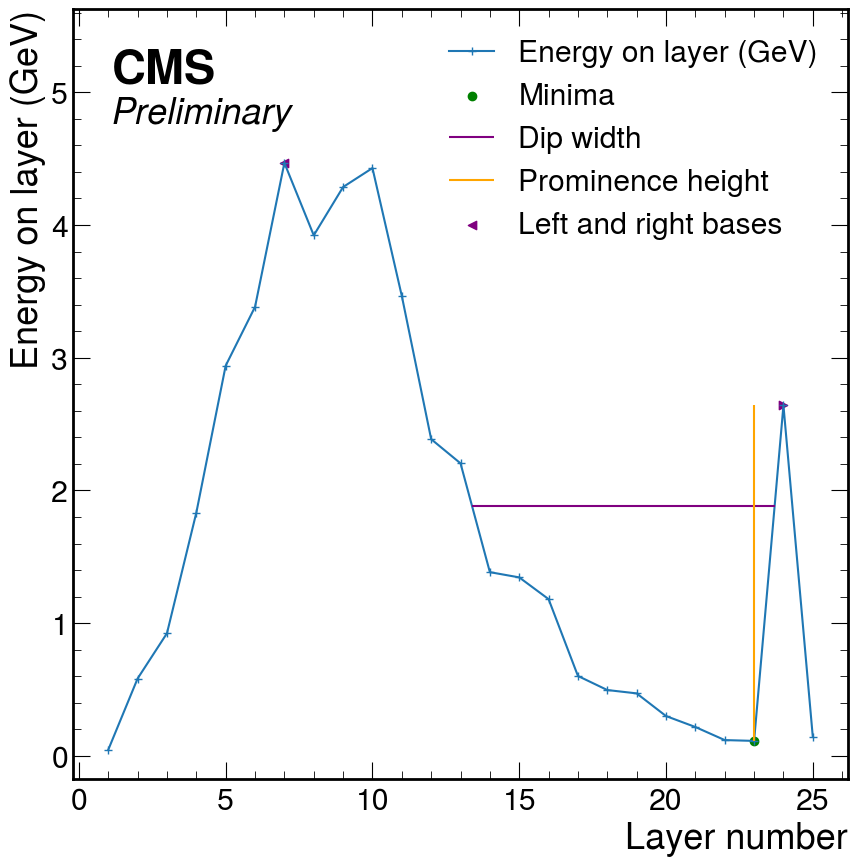

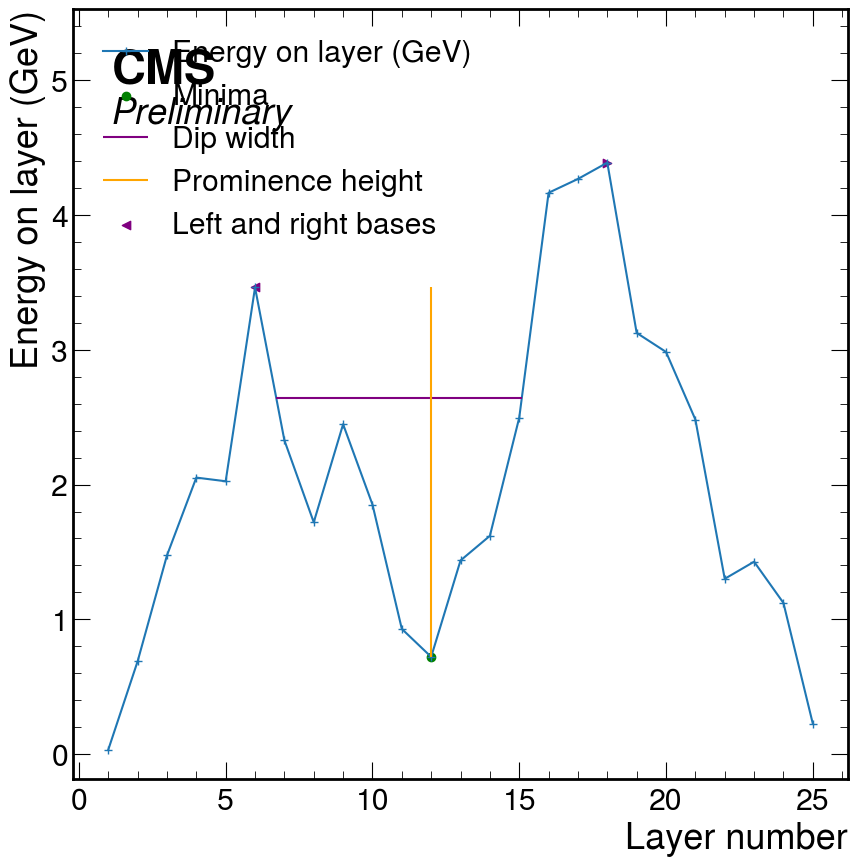

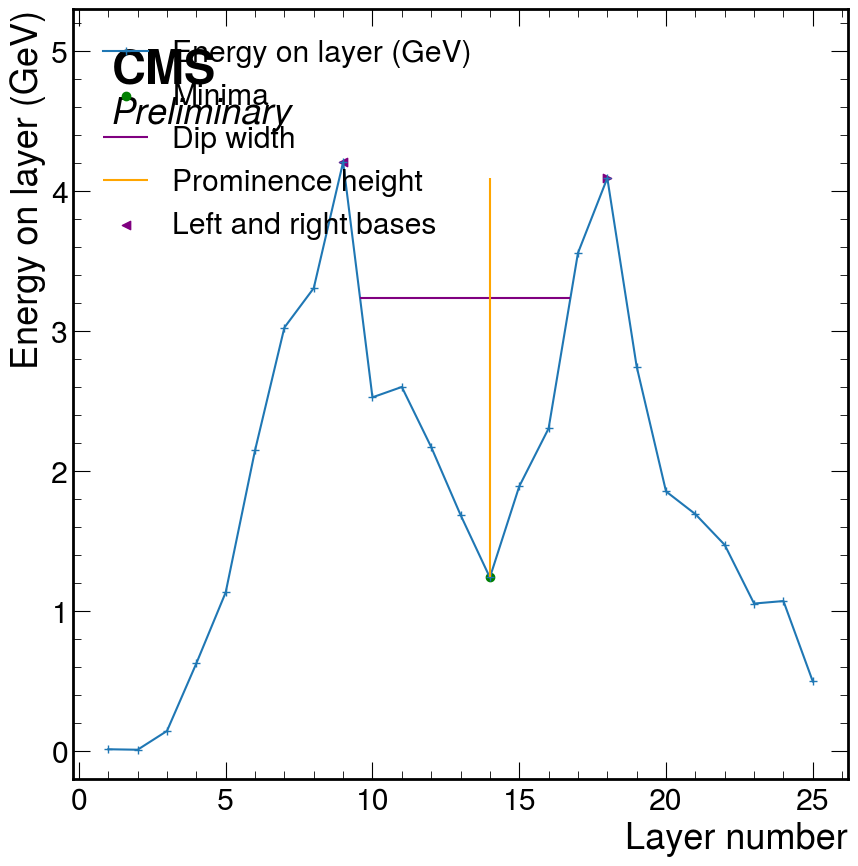

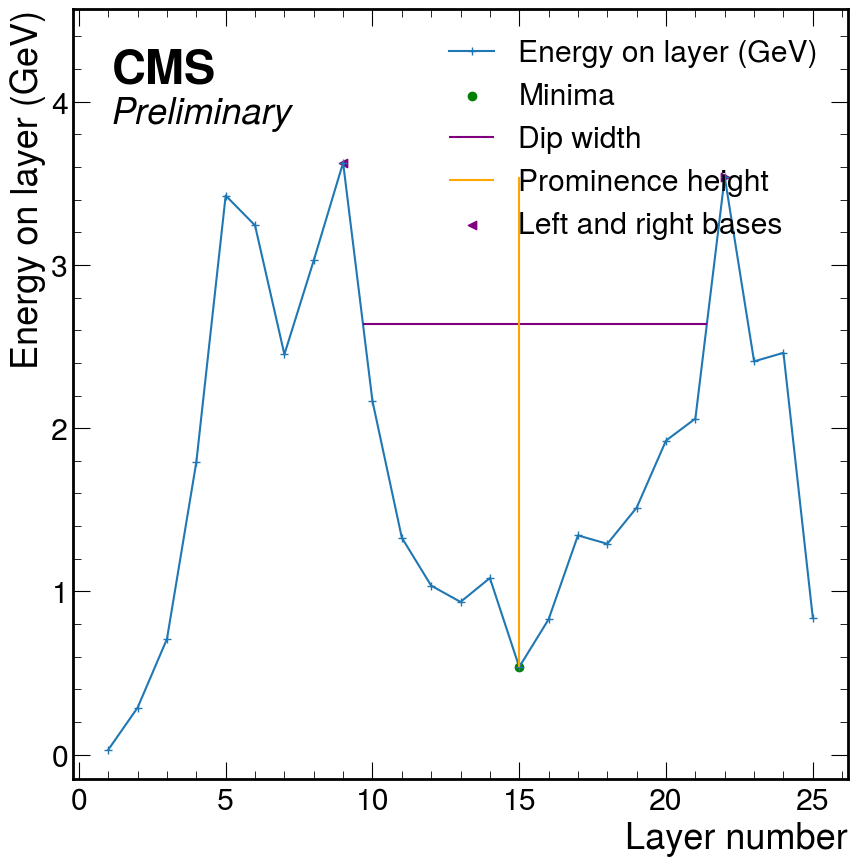

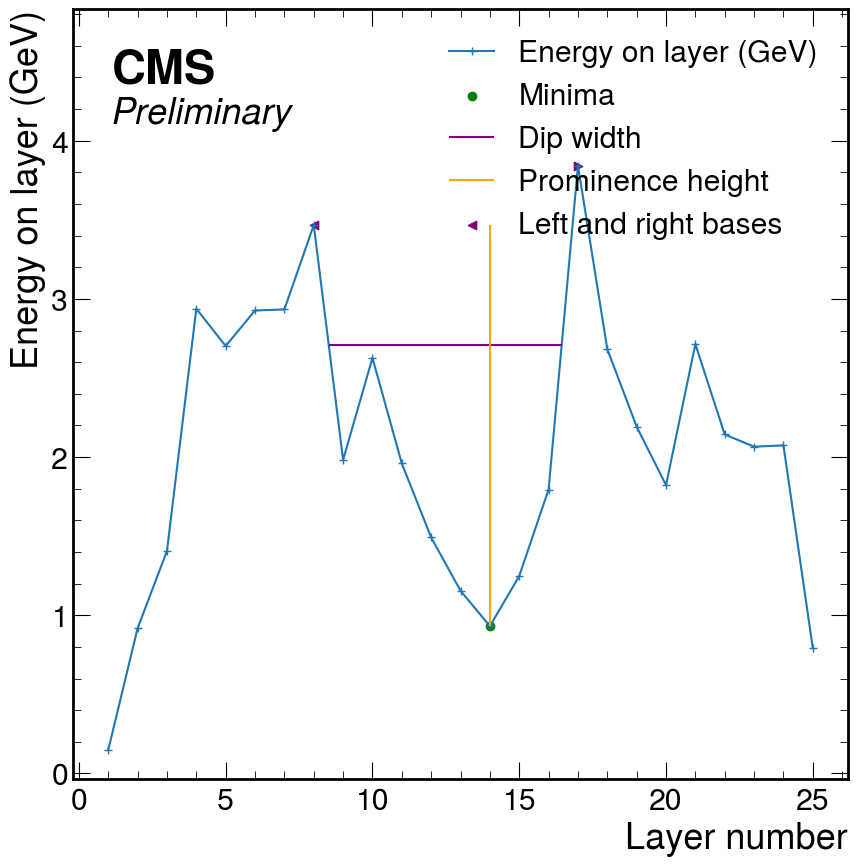

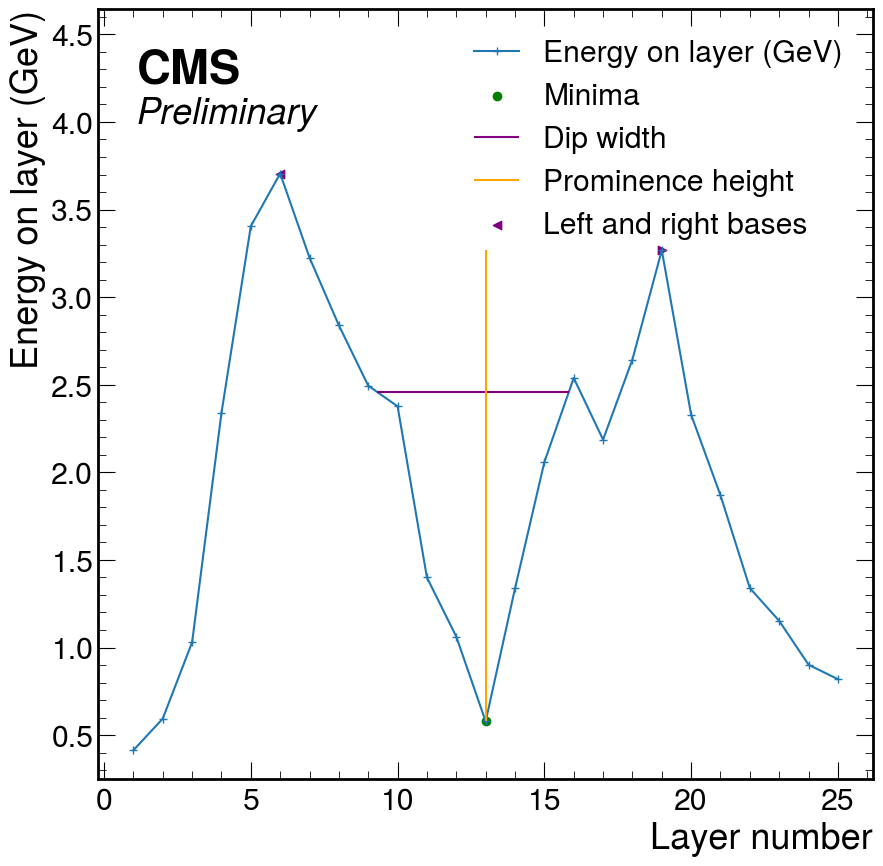

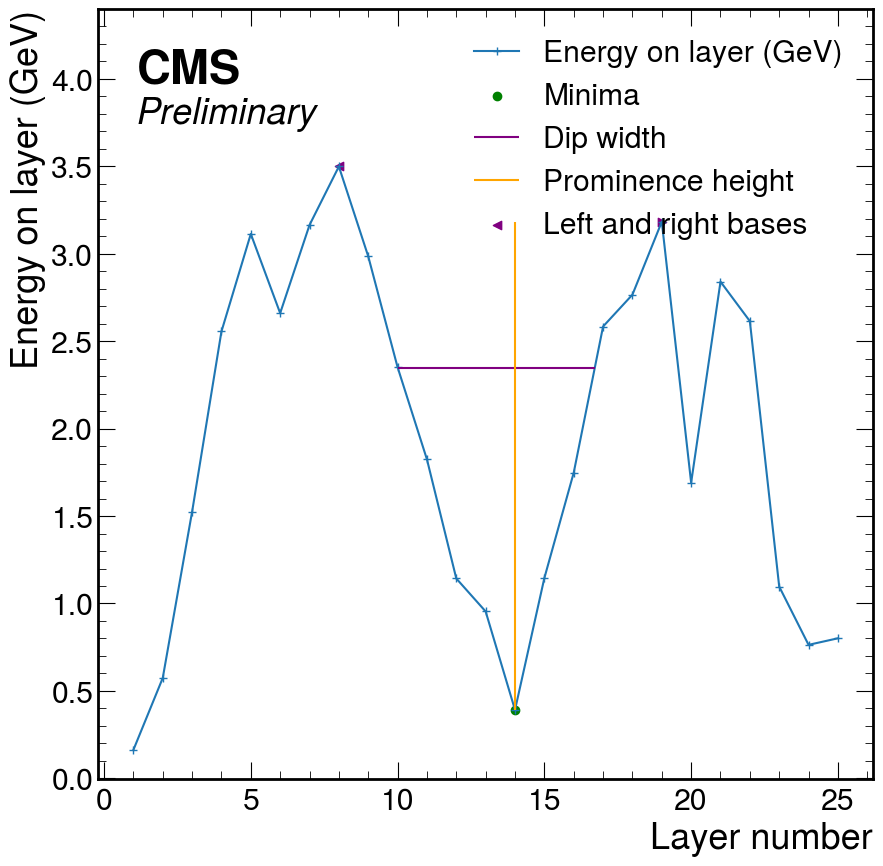

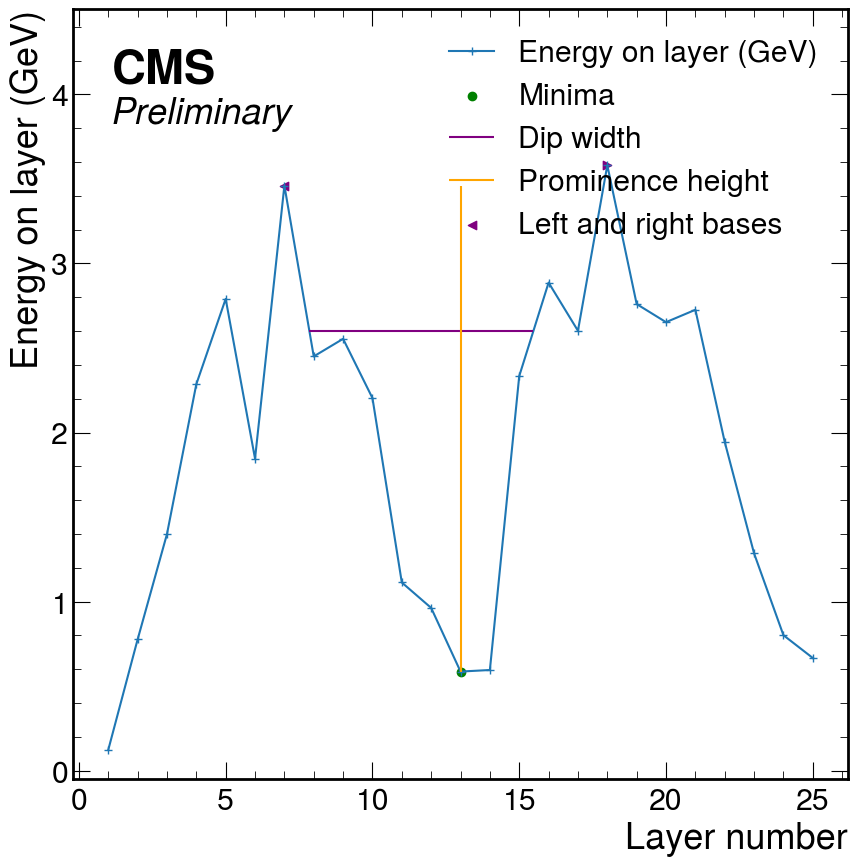

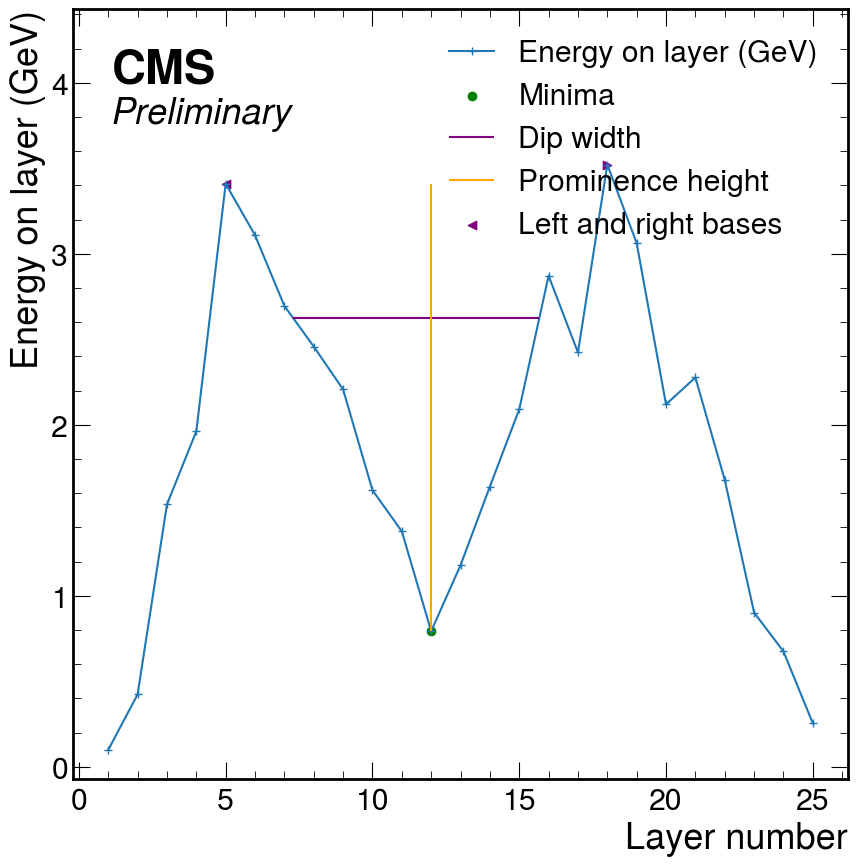

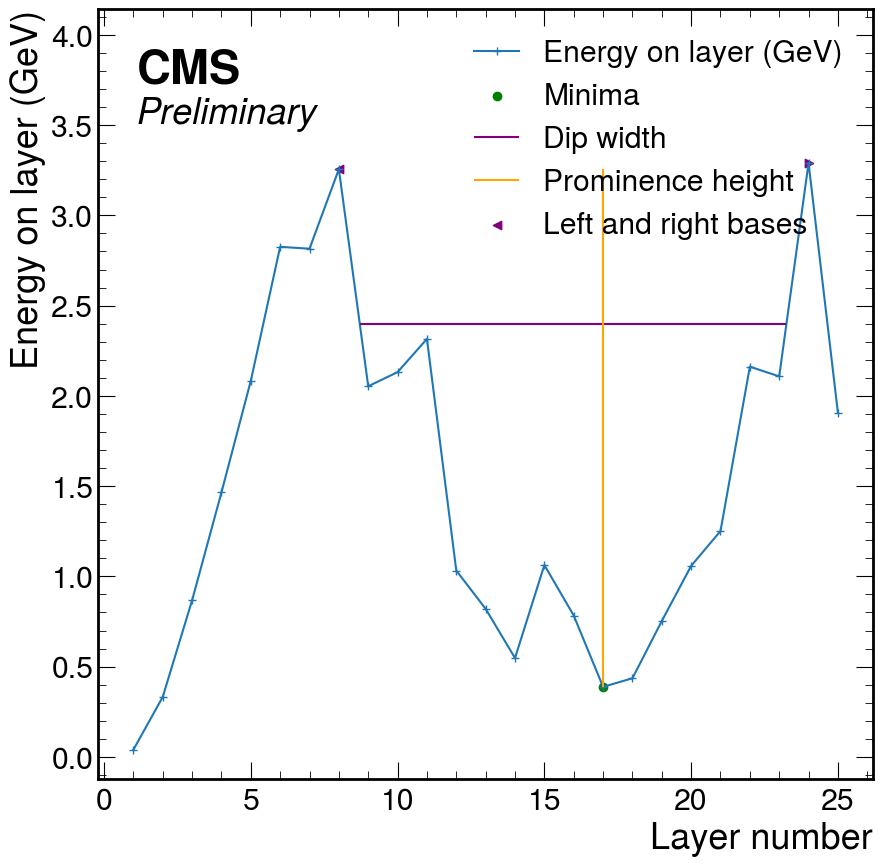

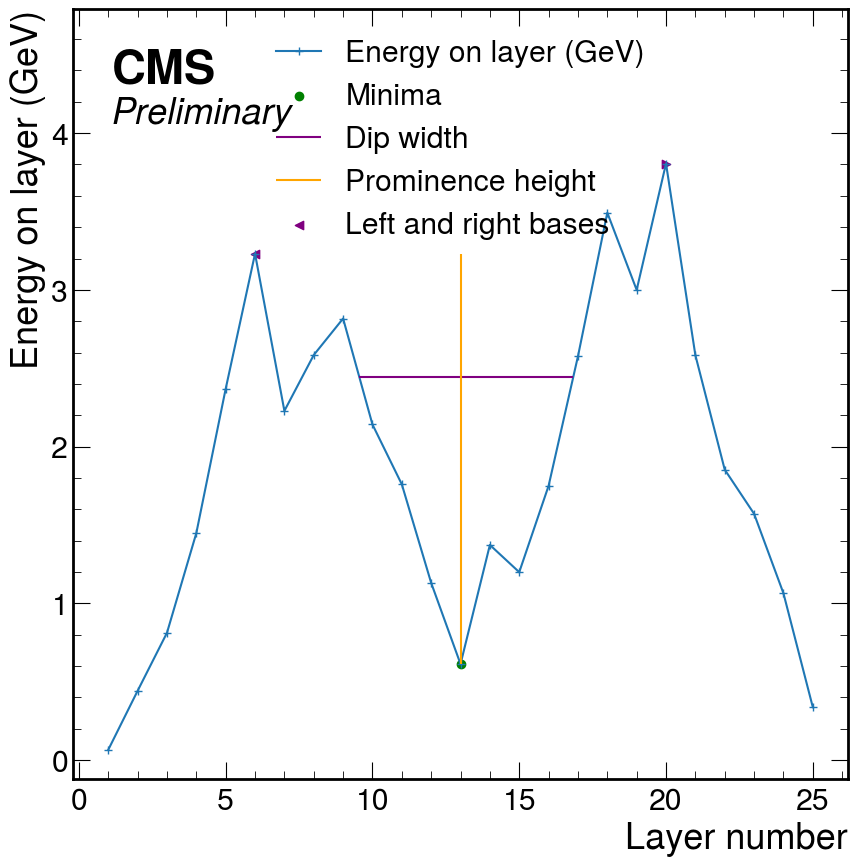

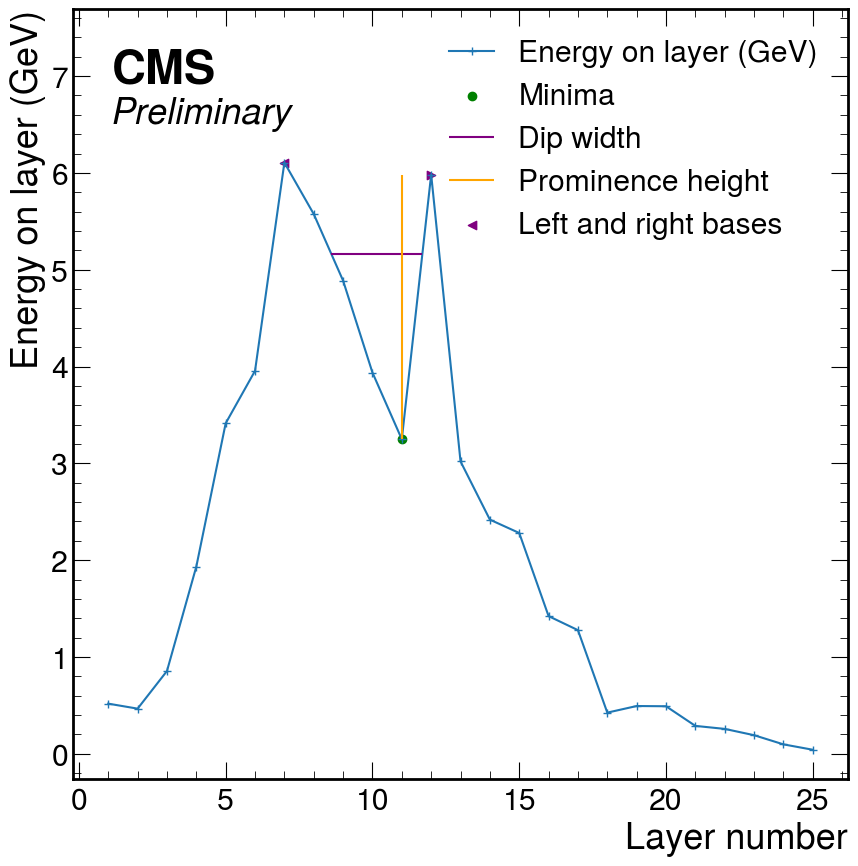

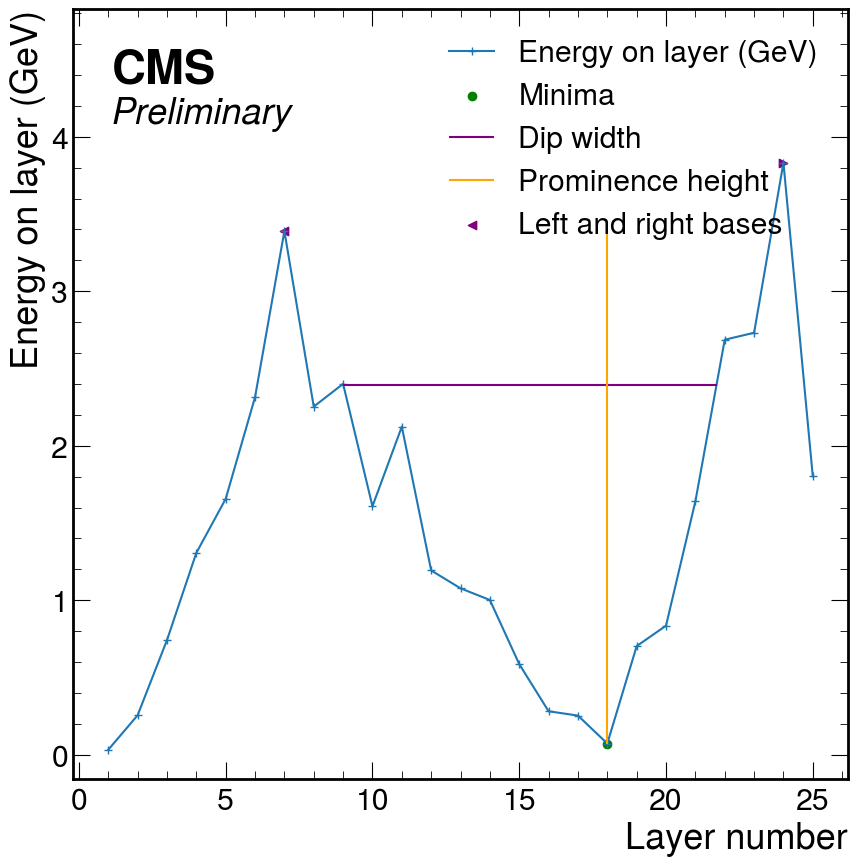

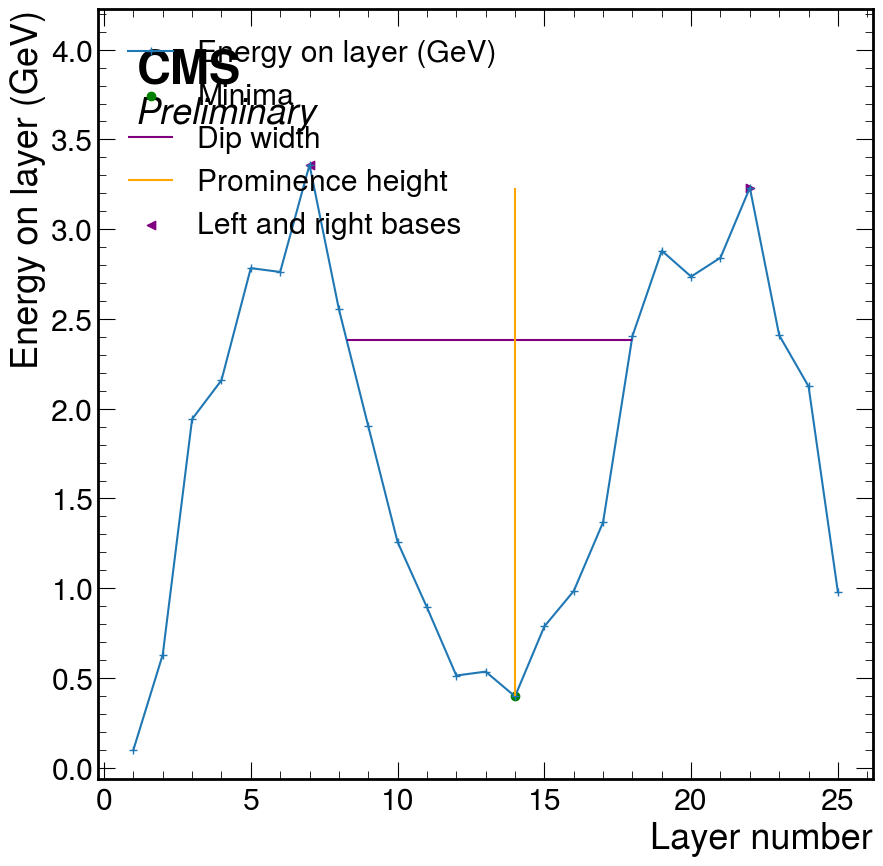

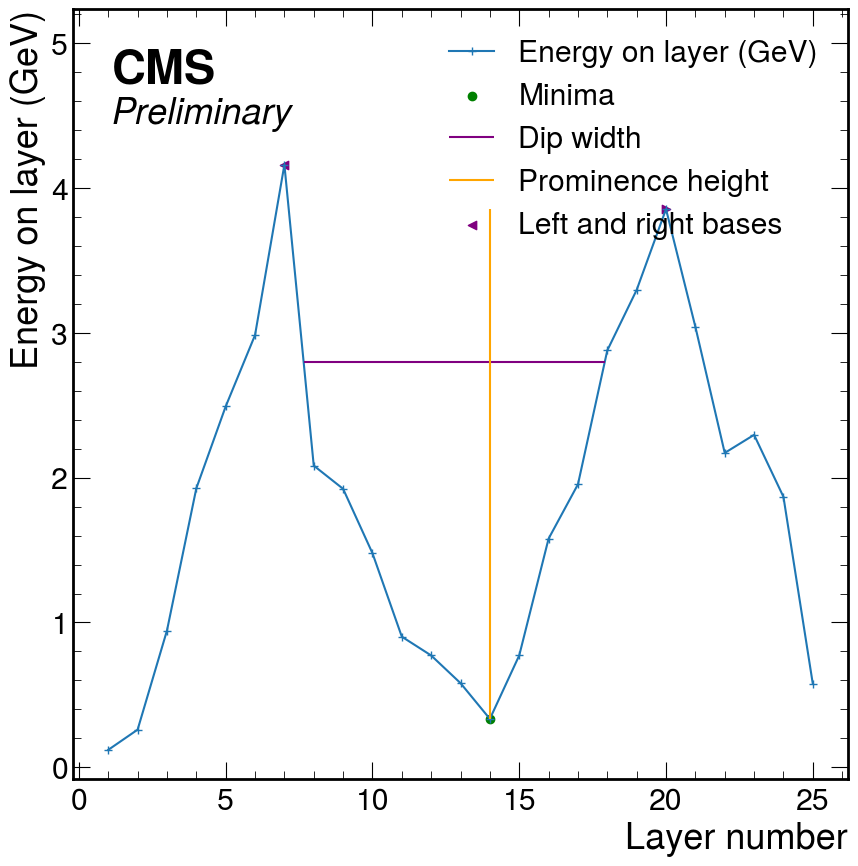

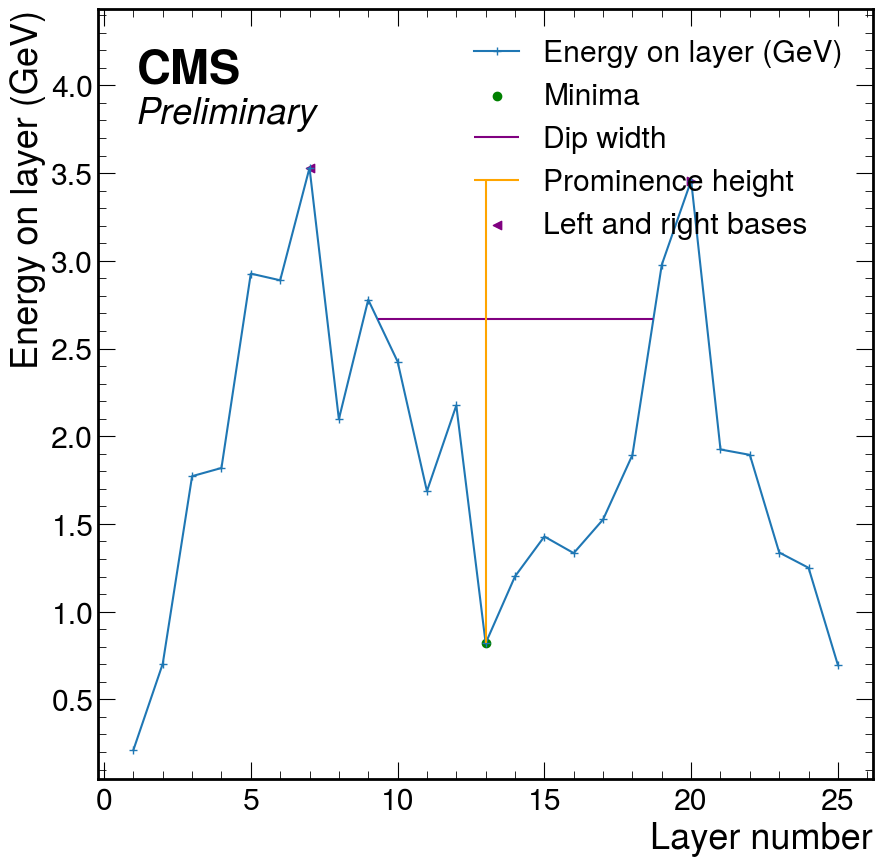

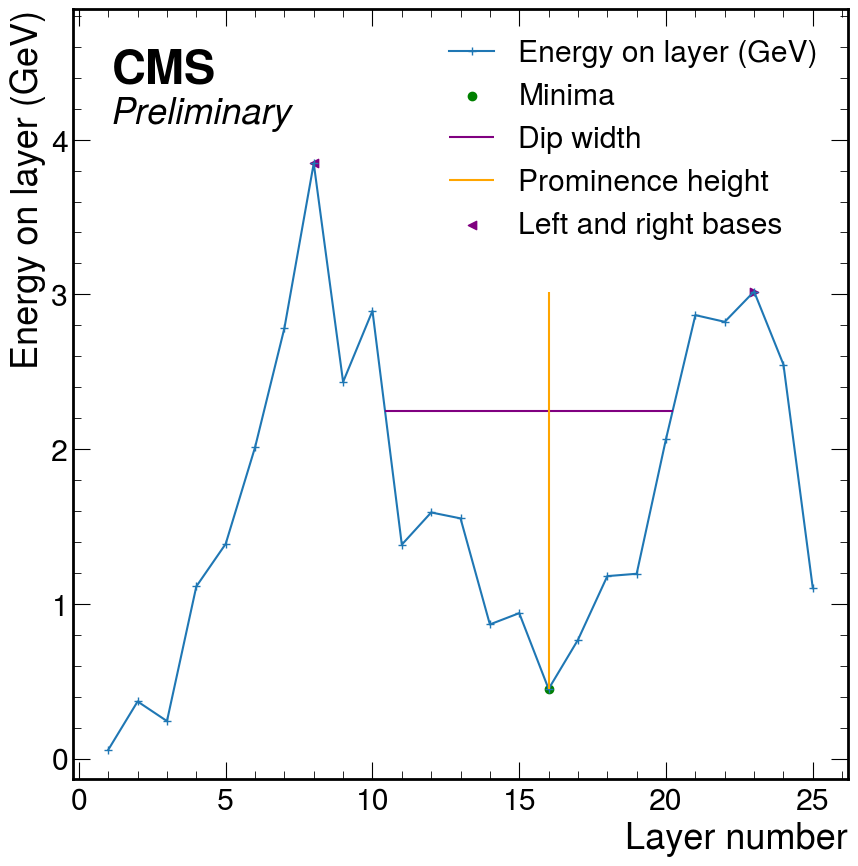

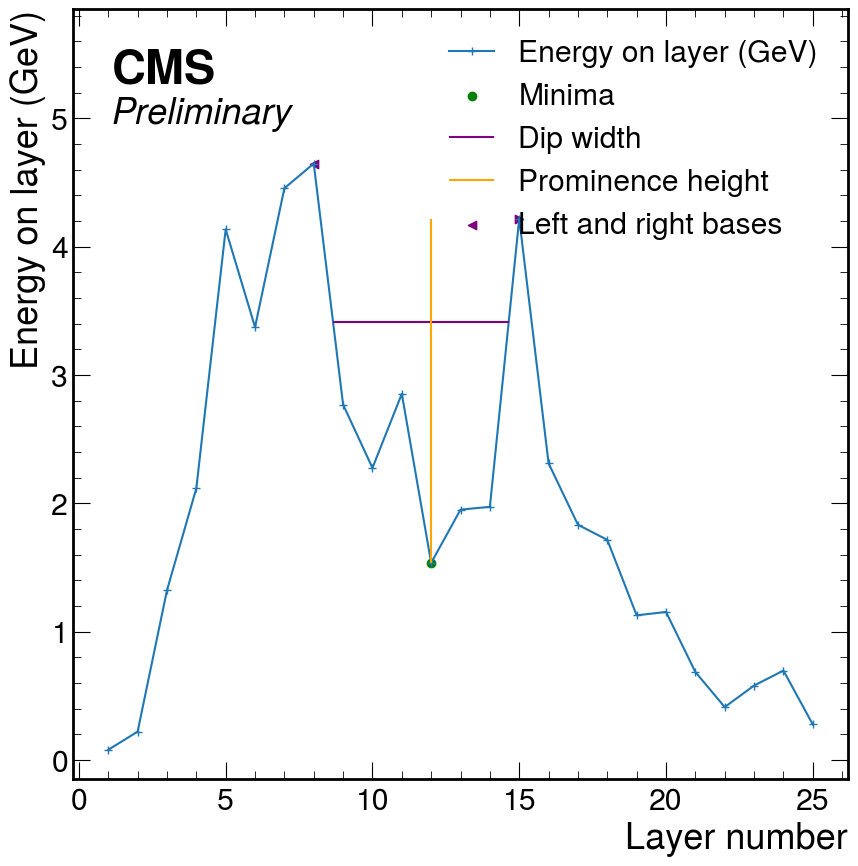

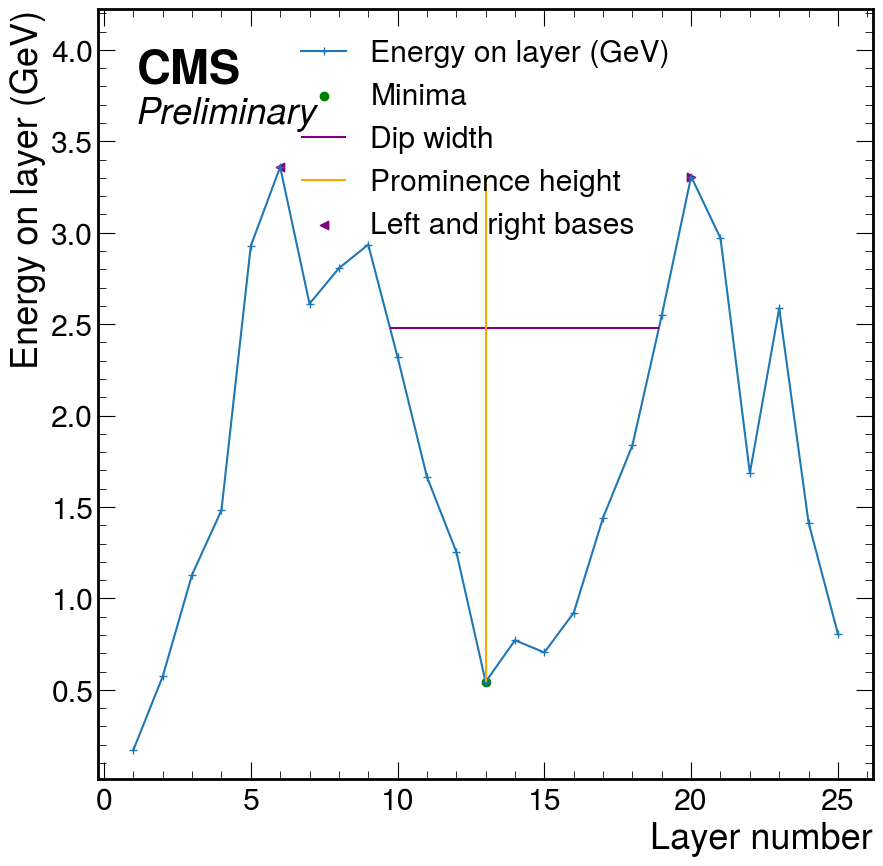

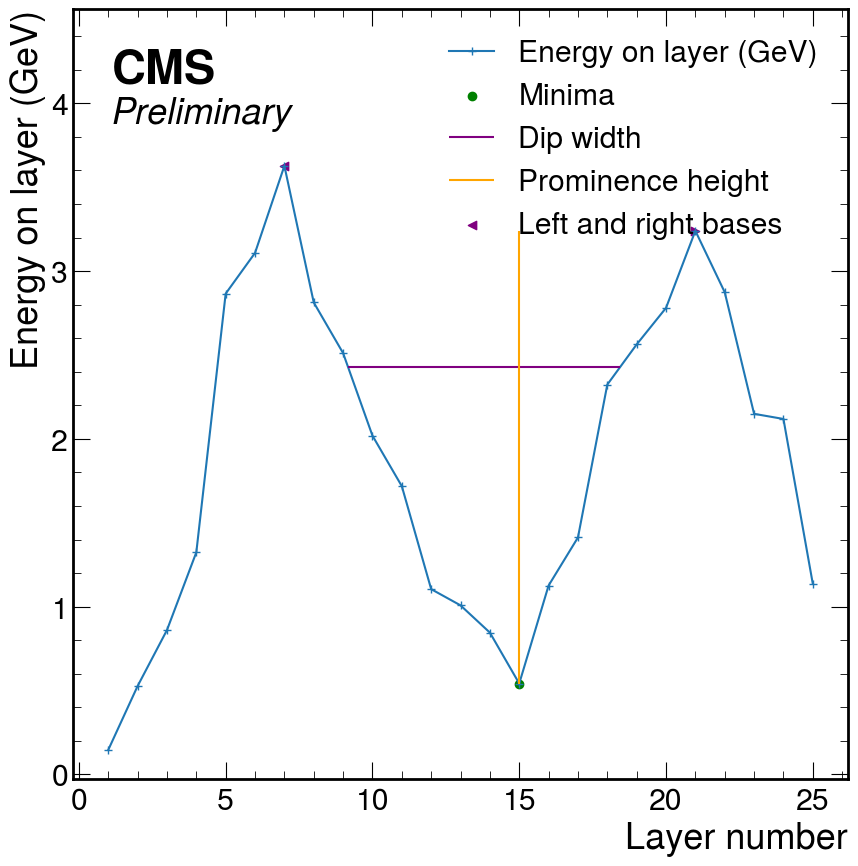

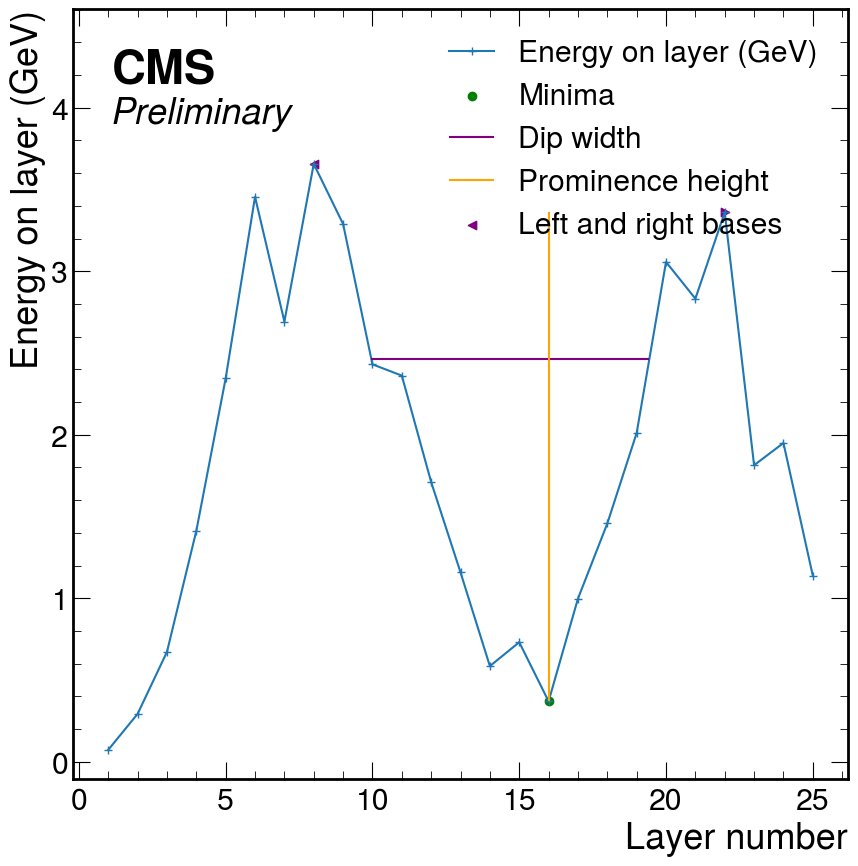

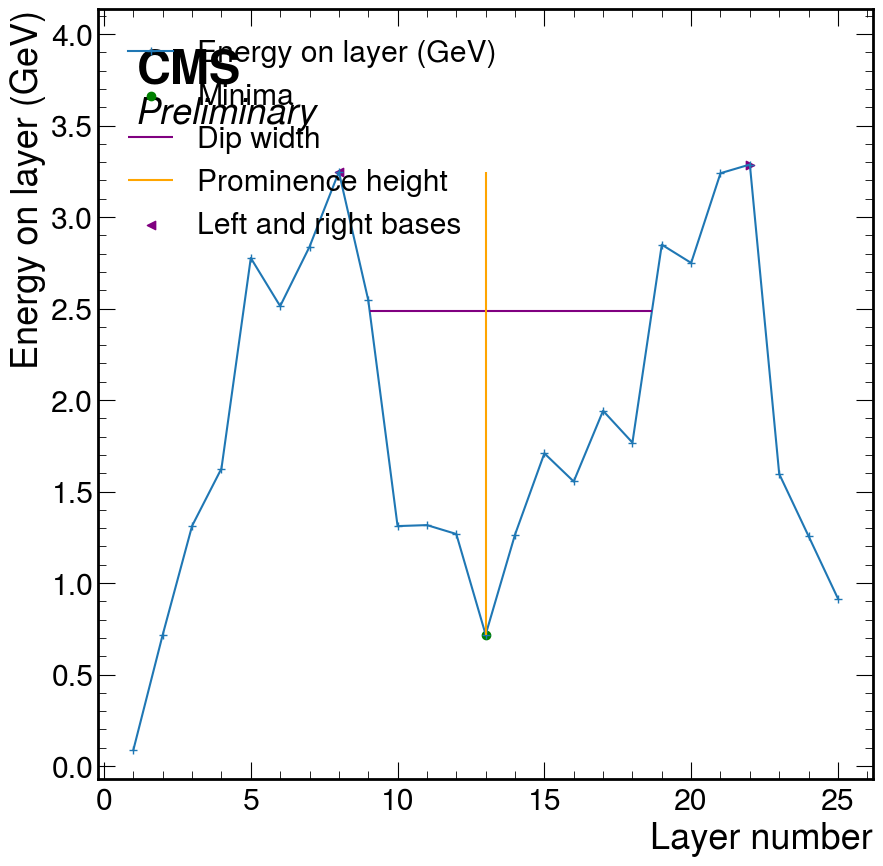

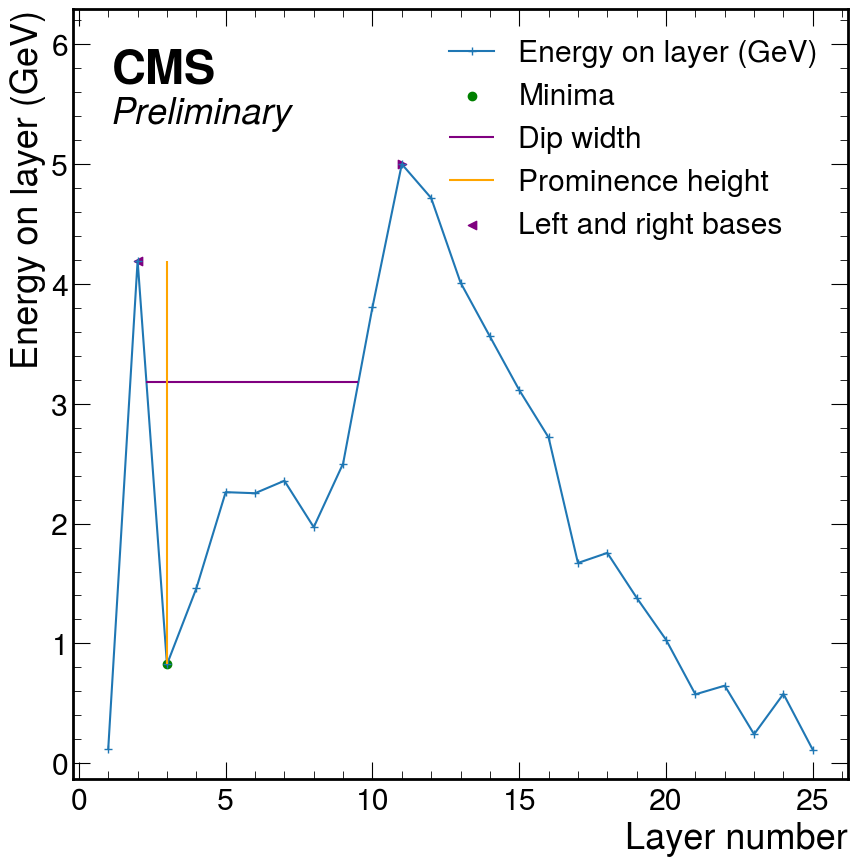

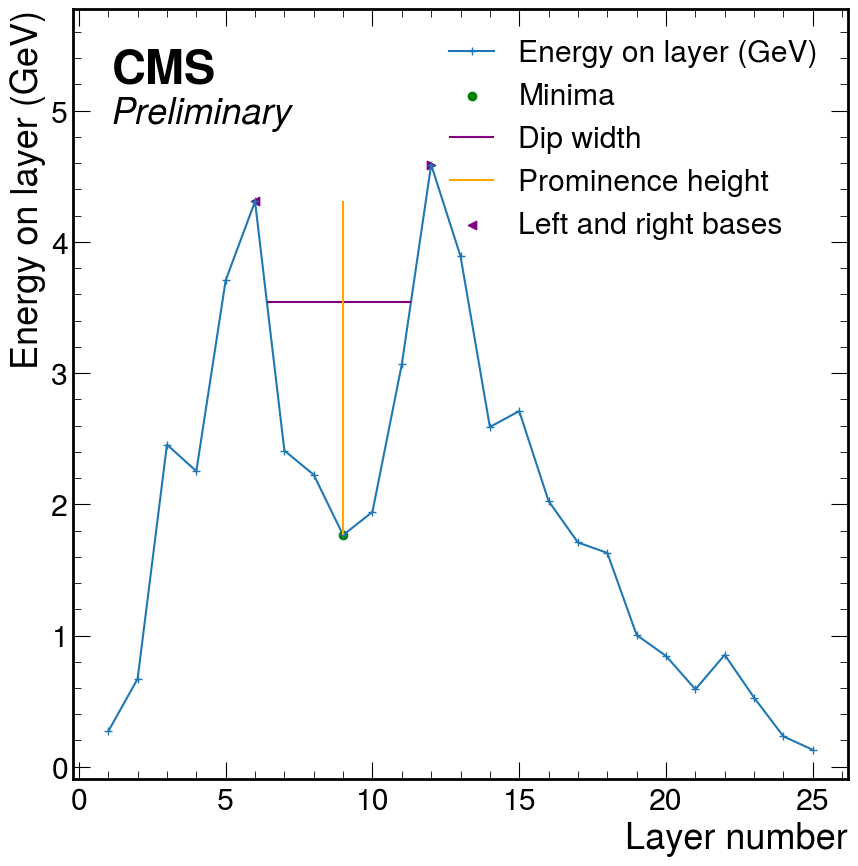

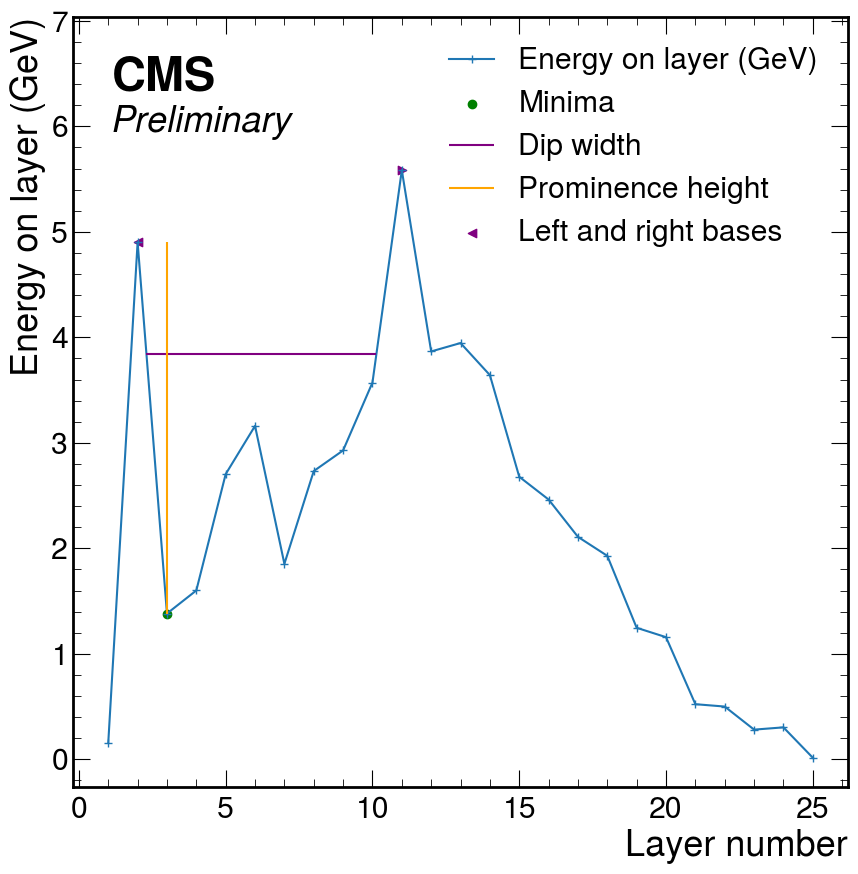

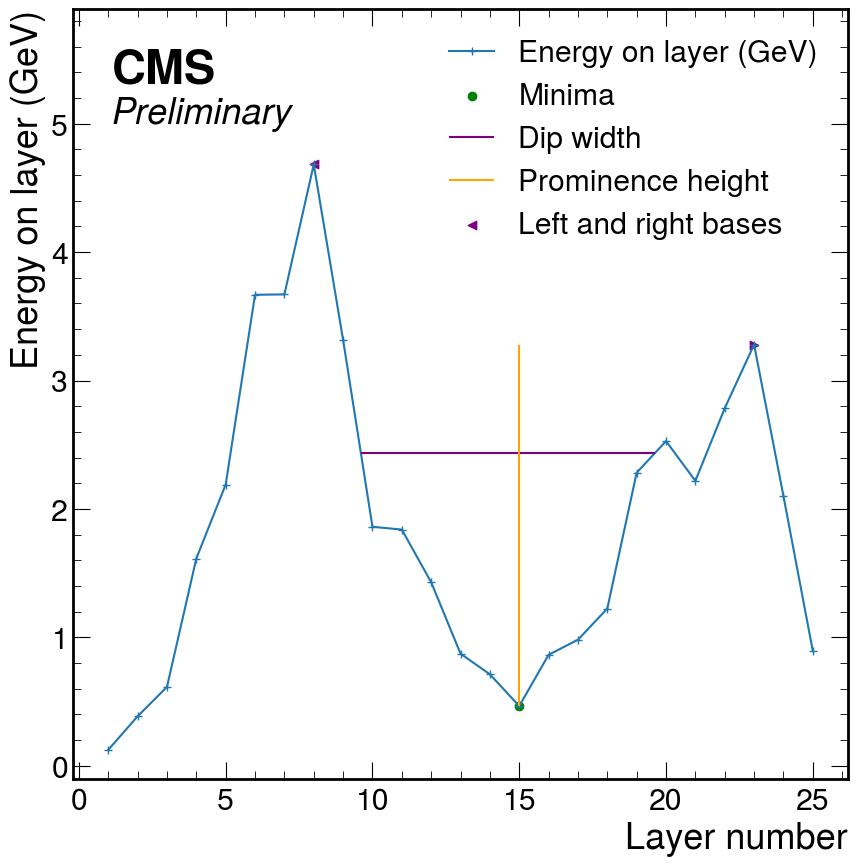

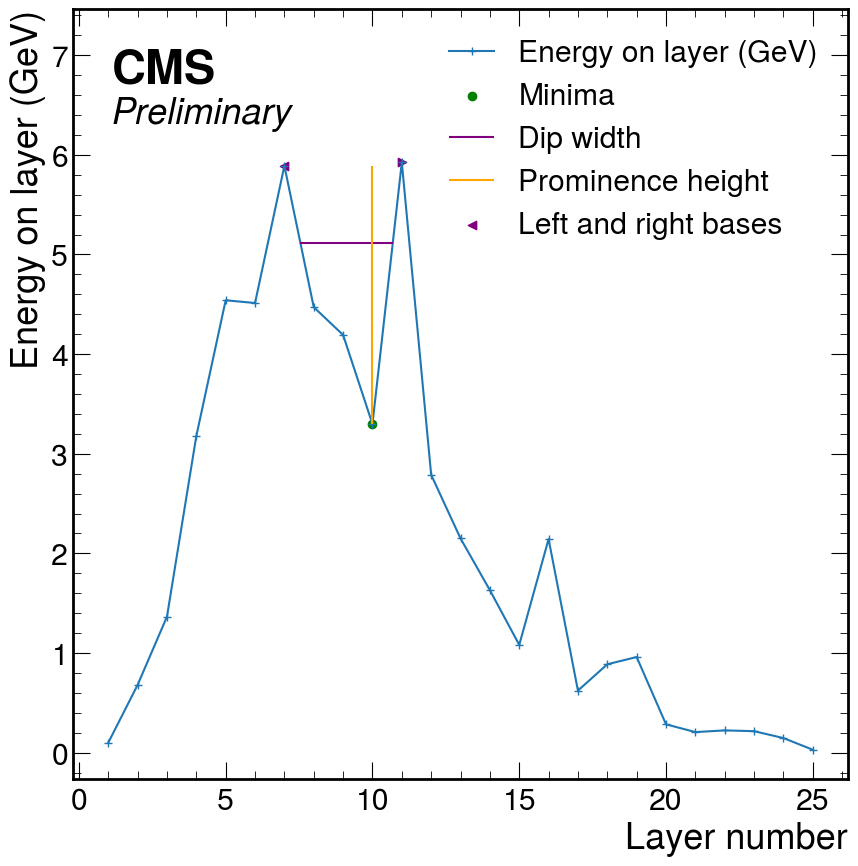

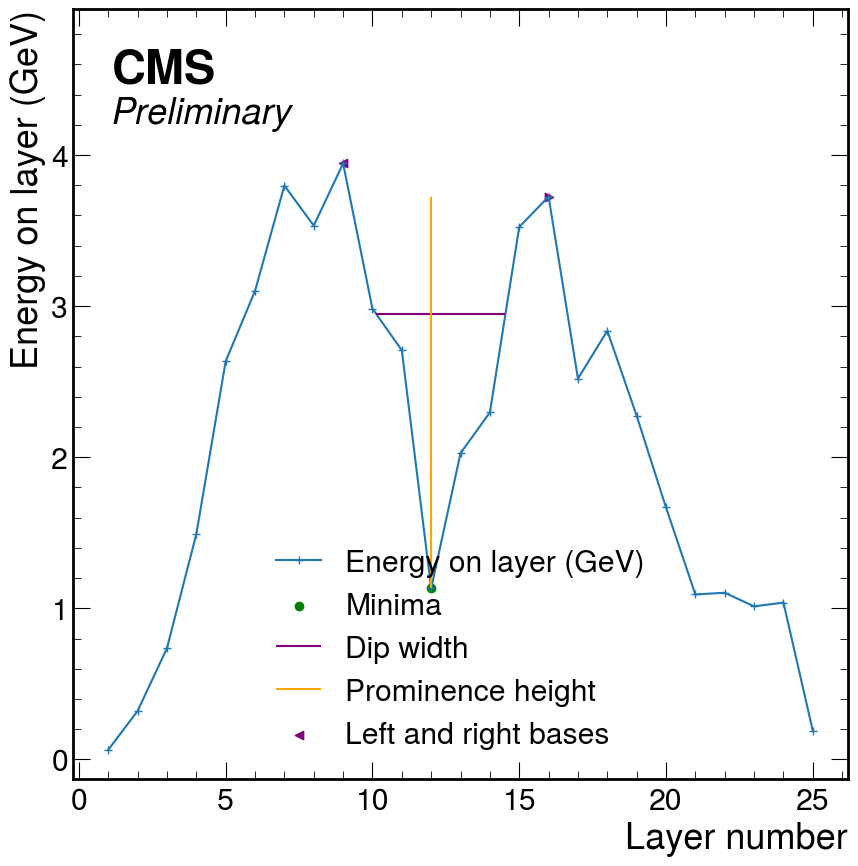

In [8]:
eventList.plotAllLongitudinalProfiles()